# Dose response curve fitting examples
We used previously established EC50s for OT-1 peptides in the model, based on regular T cells. Here, we provide a dose response experiment to show that CAR OT-1 T cells have essentially identical dose response curves of TCR antigens compared to the TCR-only T cells. 

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize, stats
import seaborn as sns
sns.set_context('talk')
idx = pd.IndexSlice
import sys, os

In [2]:
do_save_outputs = False
do_save_plots = False

In [3]:
# Relevant folders
root_dir = "../"
if root_dir not in sys.path:
    sys.path.insert(1, root_dir)
data_dir = os.path.join(root_dir, 'data', 'dose_response')
fig_dir = os.path.join(root_dir, 'figures', 'dose_response')

# Import data

### Important: this dose response is with mock-transduced T cells!
So blast T cells, T cells that go through the same process as our CD19 CAR-T cells but without transduction of a CAR.  

This means that the dose response will be very sharp, and that V4, G4 might cause very little activation. Moreover, the absolute pulse concentration EC50s might be smaller than with naive T cells. However, relative to NB4, EC50s of other peptides should line up still (except we might have problems with V4, G4). 

This is in part why we used previous EC50s in `potencies_df_2021.json`: they were established in the same kind of naive T cells that we use in the TCR/TCR antagonism experiments. 

In [4]:
df = pd.read_hdf(os.path.join(data_dir, "ot1cytEC50Df.hdf"), key="df")
# Rename Concentration_M
new_names = list(df.index.names)
new_names[new_names.index("Concentration_M")] = "Concentration (M)"
df.index = df.index.set_names(new_names)

df

Time                                                                24.0
Cytokine CAR    Spleen Peptide Concentration Concentration (M)          
IFNg     Mock   1      N4      10uM          1.000000e-05       0.945617
                               1uM           1.000000e-06       1.110432
                               100nM         1.000000e-07       0.208073
                               10nM          1.000000e-08       0.999583
                               1nM           1.000000e-09       0.279423
...                                                                  ...
TNFa     CAR_WT 3      None    1pM           1.000000e-12       0.001569
                               100fM         1.000000e-13       0.001569
                               10fM          1.000000e-14       0.001569
                               1fM           1.000000e-15       0.001569
                               0             1.000000e-16       0.001569

[6048 rows x 1 columns]

In [5]:
plotDf = df.reset_index()
log10conc_lbl = r"$\log_{10}$ Concentration (M)"
plotDf[log10conc_lbl] = np.log10(plotDf["Concentration (M)"])
g = sns.relplot(data=plotDf, x=r"$\log_{10}$ Concentration (M)", y=24.0, row="Cytokine", 
            col="CAR", style="Spleen", hue="Peptide", kind="line")
for ax in g.axes.flat:
    ax.set_yscale("log")
if do_save_plots:
    plt.show()
plt.close()

## Data cleanup
- Remove cytokines without significant signal. Basically, keep IL-2, TNF, IFNg. 
- Remove mispipette accident for Q4 at 1 pM. 
- Clip IFNg data at value for None, highest concentration. Since all "None" conditions were just unpulsed tumors, they should all be identical, yet there is a systematic bias in the background noise, which increases with pulse concentration, especially in IFNg. This might be due to layout on the plate. Anyways, to prevent fitting Hill curves on this low ramp, I clip IFNg to the highest baseline value available; everything below is noise and should be treated as lower LOD. 

In [6]:
# Detectable cytokines
df_clean = df.loc[df.index.isin(["IFNg", "IL-2", "TNFa"], level="Cytokine")]

# Mispipette of Q4 1 pM
sizes_before_after = [df_clean.shape[0]]
df_clean = df_clean.query("Peptide != 'Q4' or Concentration != '1pM'").sort_index()
sizes_before_after.append(df_clean.shape[0])
print("Size before: {0[0]}\nSize after: {0[1]}".format(sizes_before_after))
assert df.loc[(["IFNg", "IL-2", "TNFa"], slice(None), slice(None), "Q4", "1pM")].shape[0] == (sizes_before_after[0] - sizes_before_after[1])

# Clip IFNg. Baseline from Mock CARs
baseline_ifng = df_clean.loc[("IFNg", "Mock", slice(None), "None", "10nM"), :].max().max()
df_clean.loc["IFNg", :] = df_clean.loc["IFNg",:].clip(lower=baseline_ifng).values

Size before: 2592
Size after: 2565


# Hill fits

I fit Hill function in log-log scale. In other words, for $x = \log_{10} L$ with $L$ the pulse concentration, and $y = \log_{10} C$, with $C$ the cytokine concentration, I fit

$$ y = y_0 \frac{x^h}{x^h + k^h} + b $$

where $y_0$ is the amplitude, $h$ is the Hill exponent, $k$ is the EC50, and $b$ is the background. 

In [7]:
from utils.fitting import (
    r_squared, 
    find_bounds_on_min
)

# Fit each spleen separately
This gives statistics on the resulting EC50s, an assessment of the quality of fit, etc. 

Also better biologically speaking: 3 spleens are 3 separate systems responding to the different antigens. 
The response of each could be different in principle (the goal is to minimize that difference by controlling external factors in the lab though), so each should have its own fit. 

Also, avoids having to compute error bars on the fits themselves. We compute error bars on the extracted EC50s by comparing individual line fits. 


In [8]:
def hillFunction4p(x, params):
    amplitude = params[0]
    ec50 = params[1]
    background = params[2]
    hill_k = params[3]
    return amplitude * x**hill_k/(ec50**hill_k + x**hill_k) + background


# Function which computes the vector of residuals, with the signature fun(x, *args, **kwargs)
# Fitting Hill in log-log. 
def cost_fit_hill4p(hill_pms, xpts, ypts, yerr, p0, reg_rate=0.2):
    """ p0: value around which to regularize each param. L1 regularization ="""
    # Compute Hill function at xpts
    y_fit = hillFunction4p(xpts, hill_pms)
    resids = (ypts - y_fit) / yerr
    # Add in L1 regularization
    regul = np.sqrt(reg_rate*np.abs(hill_pms - p0))
    resids = np.concatenate([resids, regul])
    return resids


#@title Function to apply to each CAR type and each cytokine
# Fit Hill exponent too as grid search will be too slow for my patience otherwise
def fit_hill_cyto_each_peptide_replicate(ser, hill_k_bounds=(4, 16), conc_lbl=None, reg_rate=0.2):
    """ Input should be the log of cytokines. 
    Grid search over all integer Hill k. Consider from 1 up to max_hill. 
    """
    hill_params_dict = {}
    if conc_lbl is None:
        conc_lbl = "Concentration"
    min_conc = np.min(ser.index.get_level_values(conc_lbl).values)
    concentrations = np.log10(ser.index.get_level_values(conc_lbl).values / min_conc)
    conc_ser = pd.Series(concentrations, index=ser.index, name="log10 Concentration")
    df_fit_data = pd.concat({"log10 Cytokine":ser, "log10 Concentration":conc_ser}, axis=1)
    for peptide in pd.unique(ser.index.get_level_values('Peptide')):
        # Loop on all subdivisions other than peptide concentration, which is the x axis
        pep_ser = ser.xs(peptide, level="Peptide")
        pep_conc_ser = conc_ser.xs(peptide, level="Peptide")
        drop_lvls = [a for a in pep_ser.index.names if a.startswith("Concentr")]
        loop_idx = pep_ser.droplevel(drop_lvls).index.unique()
        # Reorder levels
        pep_ser = pep_ser.reorder_levels(list(loop_idx.names) + drop_lvls)
        pep_conc_ser = pep_conc_ser.reorder_levels(list(loop_idx.names) + drop_lvls)
        for ky in loop_idx:
            y_ser = pep_ser.loc[ky]
            x_ser = pep_conc_ser.loc[ky]
            data = y_ser.values.flatten()
            err = 1.0

            # Finding bounds on the parameter values
            # Background limits
            min_back, max_back = find_bounds_on_min(data)

            # Concentration limits: always lower=0 because rescaled
            max_conc = np.max(x_ser)*2
            if max_conc == 0:
                max_conc = 6
        
            min_conc2 = np.min(x_ser)
            data_replicates = ser.xs(peptide, level="Peptide")
            max_amplitude = (np.max(data) - np.min(data))*2.0
            if max_amplitude == 0.0:
                max_amplitude = 0.01
            lowerbounds = np.asarray([0.0, 0, min_back, hill_k_bounds[0]])
            upperbounds = np.asarray([max_amplitude, max_conc, max_back, hill_k_bounds[1]])
            # Constrain amplitude to max value recorded for that cytokine. 
            # Assume increasing further concentration would not increase further plateau level

            # Try without bounds for now
            # Params: amplitude, ec50, background, k
            regul_p0 = np.zeros(4)
            # Regularize amplitude to be at the observed amplitude, roughly
            regul_p0[0] = 0.5 * (upperbounds[0] - lowerbounds[0])
            # Regularize EC50 to be as large as possible. 
            regul_p0[1] = np.max(x_ser) + 2
            # And Hill exponent as small as possible
            regul_p0[3] = hill_k_bounds[0]
            init_p0 = (lowerbounds + upperbounds) / 2
            # Cost args: xpts, ypts, yerr, p0]
            cost_args = (x_ser, data, err, regul_p0)
            cost_kwargs = {"reg_rate":reg_rate}
            
            result = sp.optimize.least_squares(cost_fit_hill4p, init_p0, 
                        method="trf", args=cost_args,
                        kwargs=cost_kwargs,
                        bounds=[lowerbounds, upperbounds],
                )

            popt = result.x
            r2 = round(r_squared(x_ser, data, hillFunction4p, popt), 3)
            
            key = (peptide,) + tuple(ky)
            hill_params_dict[key] = pd.Series(list(popt), name="Parameters",
                index=["amplitude", "ec50", "background", "hill_power"])
            hill_params_dict[key]["rsquared"] = r2
    lvl_names = ["Peptide"] + list(loop_idx.names) + ["Parameters"]
    df_params = pd.concat(hill_params_dict, names=lvl_names, axis=0)
    df_params = df_params.unstack("Parameters")
    conc_names = [a for a in df_fit_data.index.names if a.startswith("Concentration")]
    df_fit_data = df_fit_data.reorder_levels(lvl_names[:-1] + conc_names)
    return df_params, df_fit_data

In [9]:
#@title Test on a condition that seemed problematic
df_fit = np.log10(df_clean / df_clean.groupby("Cytokine").min()).sort_index()
min_hill_k, max_hill_k = 4, 16
fit_res,  df_fit_data = fit_hill_cyto_each_peptide_replicate(df_fit.loc[("IL-2", "CAR_Mut"), 24.0], 
              hill_k_bounds=(min_hill_k, max_hill_k), conc_lbl="Concentration (M)", reg_rate=0.02)

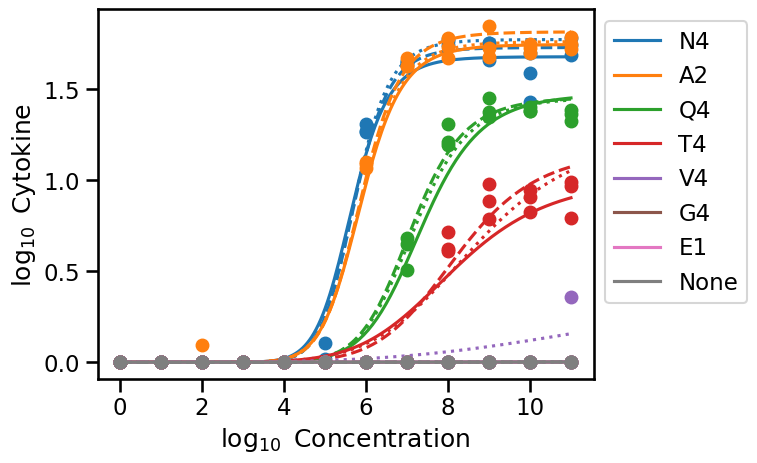

In [10]:
# Plot the test fits. 
fig, ax = plt.subplots()
pep_order = ["N4", "A2", "Q4", "T4", "V4", "G4", "E1", "None"]
pep_order = [pep for pep in pep_order if pep in fit_res.index.get_level_values("Peptide").unique()]
palette = sns.color_palette(n_colors=len(pep_order))
styles = ["-", "--", ":"]
df_data = df_fit.loc[("IL-2", "CAR_Mut"), 24.0]
for i, pep in enumerate(pep_order):
    fit_res_pep = fit_res.xs(pep, level="Peptide").sort_index()
    df_fit_pep = df_fit_data.xs(pep, level="Peptide").sort_index()
    for j, rep in enumerate(fit_res_pep.index.get_level_values("Spleen").unique()):
        x = df_fit_pep.loc[rep, "log10 Concentration"].values
        xfit = np.linspace(x.min(), x.max(), 201)
        y = df_fit_pep.loc[rep, "log10 Cytokine"].values
        pms = fit_res_pep.loc[rep, "amplitude":"hill_power"].values
        yfit = hillFunction4p(xfit, pms)
        ax.plot(x, y, marker="o", mfc=palette[i], mec=palette[i], ls="none")
        lbl = pep if j == 0 else None
        ax.plot(xfit, yfit, color=palette[i], label=lbl, ls=styles[j])
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.set(xlabel=r"$\log_{10}$ Concentration", ylabel=r"$\log_{10}$ Cytokine")
plt.show()
plt.close()

In [11]:
#@title Fit all dose response curves
df_fit = np.log10(df_clean / df_clean.groupby("Cytokine").min()).sort_index()
min_hill_k, max_hill_k = 4, 16
# Different reg. rate for each parameter. Constrain amplitude a lot. 
# amplitude, ec50, background
regular_rate = 0.01

all_fit_results4p = {}
data_to_plot4p = {}
for cyt in df_clean.index.get_level_values("Cytokine").unique():
    for car in df_clean.index.get_level_values("CAR").unique():
        print("Fitting {}, {}".format(cyt, car))
        fit_res, df_all_stats = fit_hill_cyto_each_peptide_replicate(df_fit.loc[(cyt, car), 24.0], 
              hill_k_bounds=(min_hill_k, max_hill_k), conc_lbl="Concentration (M)", reg_rate=regular_rate)
        all_fit_results4p[(cyt, car)] = fit_res
        data_to_plot4p[(cyt, car)] = df_all_stats
all_fit_results4p = pd.concat(all_fit_results4p, names=("Cytokine", "CAR")).sort_index()
data_to_plot4p = pd.concat(data_to_plot4p, names=("Cytokine", "CAR")).sort_index()
all_fit_results4p

Fitting IFNg, CAR_Mut
Fitting IFNg, CAR_WT
Fitting IFNg, Mock
Fitting IL-2, CAR_Mut
Fitting IL-2, CAR_WT
Fitting IL-2, Mock
Fitting TNFa, CAR_Mut
Fitting TNFa, CAR_WT
Fitting TNFa, Mock


Parameters                          amplitude       ec50    background  \
Cytokine CAR     Peptide Spleen                                          
IFNg     CAR_Mut A2      1       3.425735e+00   5.092030  4.293290e-01   
                         2       3.353149e+00   5.104928  3.839123e-01   
                         3       3.603886e+00   5.353275  3.426425e-01   
                 E1      1       6.574351e-10  13.000000  4.160952e-01   
                         2       3.461472e-01  13.000000  3.949308e-01   
...                                       ...        ...           ...   
TNFa     Mock    T4      2       1.373515e+00   7.641194  1.545483e-17   
                         3       1.331654e+00   7.691106  1.989072e-24   
                 V4      1       1.246490e+00  11.018515  6.542005e-18   
                         2       1.623910e+00  11.199425  6.796483e-15   
                         3       1.346000e+00  10.991330  4.660361e-21   

Parameters                       hill_power  rsquared  
Cytokine CAR     Peptide Spleen                        
IFNg     CAR_Mut A2      1        13.682850     0.992  
                         2        16.000000     0.989  
                         3        11.692978     0.992  
                 E1      1         4.000034    -0.000  
                         2         4.000164     0.214  
...                                     ...       ...  
TNFa     Mock    T4      2        16.000000     0.986  
                         3        16.000000     0.977  
                 V4      1         7.799905     0.828  
                         2         7.417086     0.973  
                         3         8.292041     0.887  

[216 rows x 5 columns]

In [12]:
# @title Plot all fit results
pep_order = ["N4", "A2", "Q4", "T4", "V4", "G4", "E1", "None"]
pep_order = [pep for pep in pep_order if pep in df_fit.index.get_level_values("Peptide").unique()]
palette = sns.color_palette(n_colors=len(pep_order))
markers = ["o", "s", "v"]
styles = ["-", "--", ":"]

# rows = cytokines, columns = CAR type
cytos, cars = df_fit.index.get_level_values("Cytokine").unique(), df_fit.index.get_level_values("CAR").unique()
#cytos = ["IL-2"]
fig, axes = plt.subplots(len(cytos), len(cars), sharey="row", sharex=True)
#axes = axes[None, :]
fig.set_size_inches(len(cars)*4.0, len(cytos)*3.5)
cytos_min_conc = df_clean.groupby("Cytokine").min()
pulse_min_conc = np.log10(np.min(df_fit.index.get_level_values("Concentration (M)").values))
for i, cyt in enumerate(cytos):
    for j, car in enumerate(cars):
        df_plot = data_to_plot4p.loc[(cyt, car)]
        fit_res = all_fit_results4p.loc[(cyt, car)]
        ax = axes[i, j]
        for p, pep in enumerate(pep_order):
            for r, rep in enumerate(fit_res.index.get_level_values("Spleen").unique()):
                x = df_plot.loc[(pep, rep), "log10 Concentration"].values
                xfit = np.linspace(x.min(), x.max(), 201)
                y = df_plot.loc[(pep, rep), "log10 Cytokine"].values
                pms = fit_res.loc[(pep, rep), "amplitude":"hill_power"].values
                yfit = hillFunction4p(xfit, pms)
                # Restore absolute cytokine scale (for y axis)
                # Error doesn't change: abs. scale is just adding a constant in log scale
                # so error bar is still y_log +- error. 
                y = y + np.log10(cytos_min_conc.loc[cyt].values)
                yfit = yfit + np.log10(cytos_min_conc.loc[cyt].values)

                # Restore absolute pulse scale (for x axis)
                x, xfit = x + pulse_min_conc, xfit + pulse_min_conc

                # Back to linear scale for plotting
                x, xfit = 10**x, 10**xfit
                y, yfit = 10**y, 10**yfit
                # Plot dose in uM, so multiply M doses by 1e6 
                lbl = (pep if r == 0 else None)
                ax.plot(x*1e6, y, marker=markers[r], mfc=palette[p], mec=palette[p], ls="none", ms=6)
                ax.plot(xfit*1e6, yfit, color=palette[p], label=lbl, ls=styles[r])
        ax.set(xscale="log", yscale="log")
# Label and legend as appropriate
for j in range(len(cars)):
    axes[-1, j].set_xlabel(r"Pulse ($\mu$M)")
    axes[0, j].set_title(cars[j])
for i in range(len(cytos)):
    axes[i, 0].set_ylabel("[{}] (nM)".format(cytos[i]))
leg = fig.legend(*axes[0, 0].get_legend_handles_labels(), loc="upper left", 
                 bbox_to_anchor=(0.99, 0.95), frameon=False)
fig.tight_layout()
if do_save_plots:
    fig.savefig("../figures/dose_response/ot1_ec50_dose_response_log_hill_fits.pdf", transparent=True, 
                bbox_inches="tight", bbox_extra_artists=(leg,))
    plt.show()
plt.close()

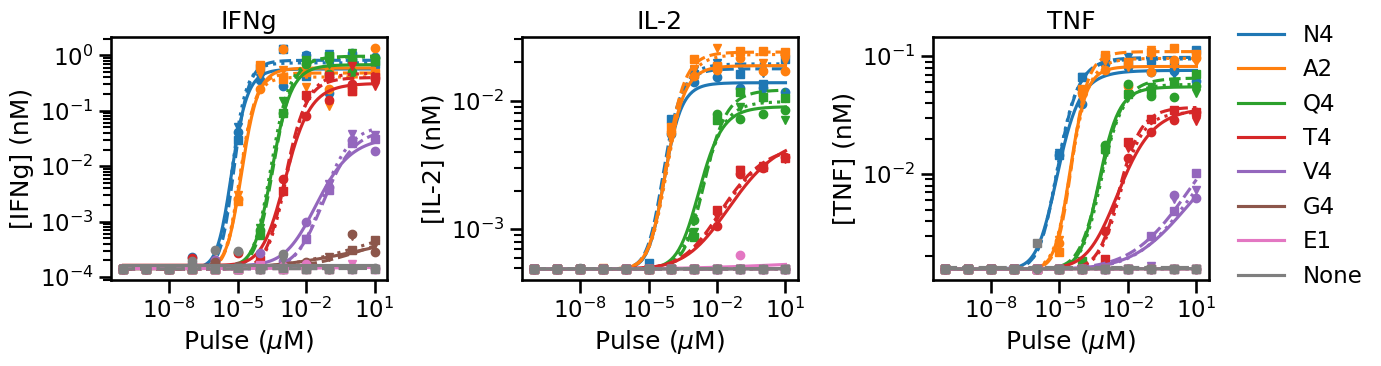

In [13]:
# Summary version with only 2 cytokines, takes less space
# @title Plot all fit results
pep_order = ["N4", "A2", "Q4", "T4", "V4", "G4", "E1", "None"]
pep_order = [pep for pep in pep_order if pep in df_fit.index.get_level_values("Peptide").unique()]
palette = sns.color_palette(n_colors=len(pep_order))
markers = ["o", "s", "v"]
styles = ["-", "--", ":"]

# rows = cytokines, columns = CAR type
cytos, cars = df_fit.index.get_level_values("Cytokine").unique(), df_fit.index.get_level_values("CAR").unique()
cars = ["Mock"]
fig, axes = plt.subplots(1, len(cytos), sharex=True)
axes = axes[:, None]
fig.set_size_inches(len(cytos)*4.2, 4.0)
cytos_min_conc = df_clean.groupby("Cytokine").min()
pulse_min_conc = np.log10(np.min(df_fit.index.get_level_values("Concentration (M)").values))
for i, cyt in enumerate(cytos):
    for j, car in enumerate(cars):
        df_plot = data_to_plot4p.loc[(cyt, car)]
        fit_res = all_fit_results4p.loc[(cyt, car)]
        ax = axes[i, j]
        for p, pep in enumerate(pep_order):
            for r, rep in enumerate(fit_res.index.get_level_values("Spleen").unique()):
                x = df_plot.loc[(pep, rep), "log10 Concentration"].values
                xfit = np.linspace(x.min(), x.max(), 201)
                y = df_plot.loc[(pep, rep), "log10 Cytokine"].values
                pms = fit_res.loc[(pep, rep), "amplitude":"hill_power"].values
                yfit = hillFunction4p(xfit, pms)
                # Restore absolute cytokine scale (for y axis)
                # Error doesn't change: abs. scale is just adding a constant in log scale
                # so error bar is still y_log +- error. 
                y = y + np.log10(cytos_min_conc.loc[cyt].values)
                yfit = yfit + np.log10(cytos_min_conc.loc[cyt].values)

                # Restore absolute pulse scale (for x axis)
                x, xfit = x + pulse_min_conc, xfit + pulse_min_conc

                # Back to linear scale for plotting
                x, xfit = 10**x, 10**xfit
                y, yfit = 10**y, 10**yfit
                # Plot dose in uM, so multiply M doses by 1e6 
                lbl = (pep if r == 0 else None)
                ax.plot(x*1e6, y, marker=markers[r], mfc=palette[p], mec=palette[p], ls="none", ms=6)
                ax.plot(xfit*1e6, yfit, color=palette[p], label=lbl, ls=styles[r])
        ax.set(xscale="log", yscale="log")
# Label and legend as appropriate
for i in range(len(cytos)):
    cytolbl = "TNF" if cytos[i] == "TNFa" else cytos[i]
    axes[i, 0].set_xlabel(r"Pulse ($\mu$M)")
    axes[i, 0].set_title(cytolbl)
    axes[i, 0].set_ylabel("[{}] (nM)".format(cytolbl))
leg = fig.legend(*axes[0, 0].get_legend_handles_labels(), loc="upper left", 
                 bbox_to_anchor=(0.98, 0.95), frameon=False)
fig.tight_layout()
if do_save_plots:
    fig.savefig("../figures/dose_response/ot1_ec50_dose_response_summary.pdf", transparent=True, 
                bbox_inches="tight", bbox_extra_artists=(leg,))
plt.show()
plt.close()

# EC50s based on CD25
For comparison of cell lines and further model predictions. This part will generate `experimental_peptide_ec50s_blasts.h5`. 

In [14]:
df_cd25 = pd.read_hdf(os.path.join(data_dir, "fullCD25EC50df.hdf"), key="df")
new_names = list(df_cd25.index.names)
new_names[new_names.index("Concentration_M")] = "Concentration (M)"
df_cd25.index = df_cd25.index.set_names(new_names)
df_cd25

Metric                                                  Percent_CD25+
TCR  Replicate Peptide Concentration Concentration (M)               
OT1  1         N4      10uM          1.000000e-05               89.60
                       1uM           1.000000e-06               90.20
                       100nM         1.000000e-07               89.70
                       10nM          1.000000e-08               88.50
                       1nM           1.000000e-09               85.60
...                                                               ...
HHAT 3         WT      10nM          1.000000e-08                1.27
                       1nM           1.000000e-09                0.70
                       100pM         1.000000e-10                0.63
                       10pM          1.000000e-11                0.67
                       0             1.000000e-16                0.89

[420 rows x 1 columns]

In [15]:
#@title Fit all dose response curves with sigmoid. Fit each spleen separately. 
df_fit = df_cd25.sort_index()  #np.log10(df_cd25)# / df_cd25.min())
# Different reg. rate for each parameter. Constrain amplitude a lot. 
# amplitude, ec50, background
regular_rate = 0.05

all_fit_results_cd25 = {}
data_to_plot_cd25 = {}
for tcr in df_cd25.index.get_level_values("TCR").unique():
    print("Fitting {}".format(tcr))
    fit_res, fit_data = fit_hill_cyto_each_peptide_replicate(df_fit.loc[tcr, "Percent_CD25+"], 
          conc_lbl="Concentration (M)", reg_rate=regular_rate)
    all_fit_results_cd25[tcr] = fit_res
    data_to_plot_cd25[tcr] = fit_data
all_fit_results_cd25 = pd.concat(all_fit_results_cd25, names=("TCR",))
data_to_plot_cd25 = pd.concat(data_to_plot_cd25, names=("TCR",))
all_fit_results_cd25 = all_fit_results_cd25.sort_index()
data_to_plot_cd25 = data_to_plot_cd25.sort_index()
all_fit_results_cd25

Fitting OT1
Fitting NYESO
Fitting HHAT


Parameters                amplitude       ec50  background  hill_power  \
TCR   Peptide Replicate                                                  
HHAT  WT      1            7.540000  11.113372    1.473631   15.268184   
              2            2.940000  12.102870    0.856064    6.151160   
              3            4.140000  11.481728    0.745431   10.473414   
      p8F     1           73.046832   7.668933    0.605000   16.000000   
              2           78.914887   7.746512    0.345000   16.000000   
              3           70.026210   7.961924    0.470000   16.000000   
NYESO 4A5P8K  1            1.197286  13.000000    4.413062    4.000087   
              2            3.680002  11.897282    7.406785   16.000000   
              3            0.458502  13.000000    2.760284    4.000000   
      8K      1           14.740000  11.231435    5.283502   12.262575   
              2           13.800000  11.214806    7.847154   16.000000   
              3           14.040000  11.130067    3.091790   16.000000   
      8S      1           65.660000  11.077861    4.787755   11.773296   
              2           64.020000  11.058370    9.138426   13.062212   
              3           54.057676  10.871560    3.320438   16.000000   
      9C      1           99.679660  10.372093    2.887626   16.000000   
              2          128.792826  10.837683    6.074334   15.512081   
              3          110.247033  10.672203    2.015816   16.000000   
      9V      1           84.815879   7.218314    3.122166   12.888736   
              2           83.920621   7.220607    7.675680   14.854728   
              3           81.166280   7.243417    1.880008   14.354243   
OT1   A2      1           88.951379   6.234390    0.236237   13.459539   
              2           87.362803   6.106210    0.669594   15.672200   
              3           85.676113   6.193676    0.635975   16.000000   
      E1      1            0.841546  13.000000    1.000000    4.000128   
              2            0.485945  13.000000    1.383954    4.000310   
              3            0.364932  13.000000    1.466358    4.000000   
      G4      1            2.620000  12.465276    0.674082    5.338579   
              2            5.360000  11.393978    1.017119    8.166602   
              3            5.115183  10.381245    0.818119   13.003660   
      N4      1           88.468998   5.542046    0.866169   16.000000   
              2           87.357578   5.496649    1.606242   16.000000   
              3           86.509853   5.566319    1.735706   15.612684   
      Q4      1           80.297547   7.569357    0.940000   16.000000   
              2           81.791216   7.565101    1.140900   16.000000   
              3           78.043534   7.534523    1.292328   16.000000   
      T4      1           45.109833   7.929700    0.267383   16.000000   
              2           54.629930   7.903682    0.340001   16.000000   
              3           57.031907   8.118049    0.623273   16.000000   
      V4      1           10.173400   9.262358    0.591055   12.114140   
              2           15.959737  10.105867    0.944152   11.815098   
              3           13.934627  10.137297    0.936356   10.181983   

Parameters               rsquared  
TCR   Peptide Replicate            
HHAT  WT      1             0.985  
              2             0.817  
              3             0.816  
      p8F     1             0.987  
              2             0.988  
              3             0.990  
NYESO 4A5P8K  1             0.028  
              2             0.062  
              3            -0.015  
      8K      1             0.955  
              2             0.925  
              3             0.979  
      8S      1             0.992  
              2             0.996  
              3             1.000  
      9C      1             0.996  
              2             0.999  
              3             0.999  
      9V      1        

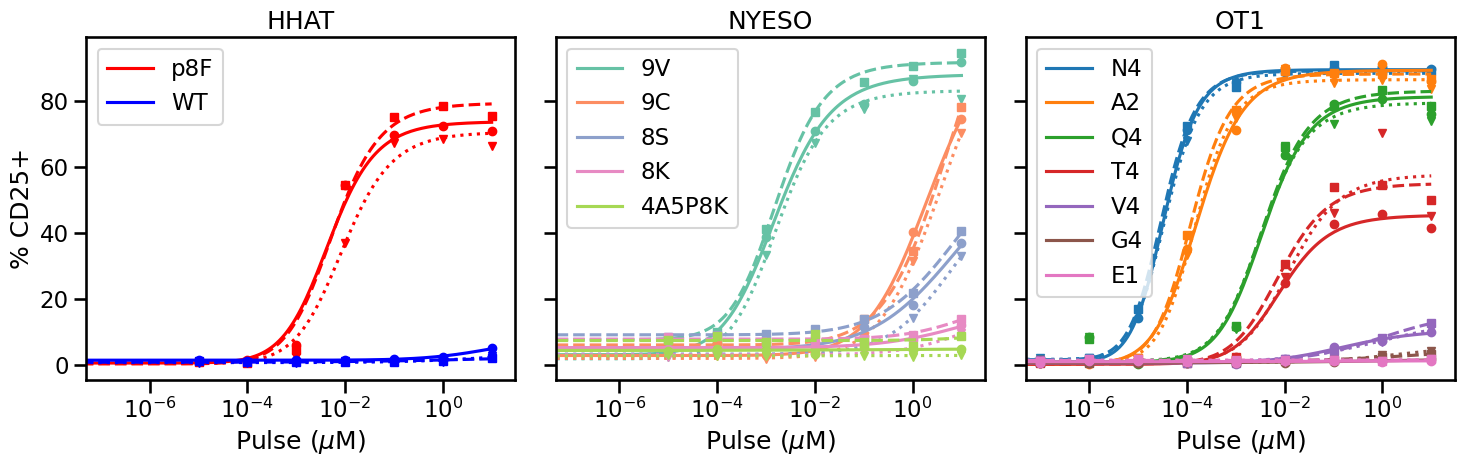

In [16]:
# @title Plot all fit results
tcr_order = ["OT1", "NYESO", "HHAT"]
pep_orders = {
    "OT1": ["N4", "A2", "Q4", "T4", "V4", "G4", "E1"], 
    "NYESO": ["9V", "9C", "8S", "8K", "4A5P8K"], 
    "HHAT": ["p8F", "WT"]
}
palettes = {
    "OT1": sns.color_palette(n_colors=len(pep_orders["OT1"])), 
    "NYESO": sns.color_palette("Set2", n_colors=len(pep_orders["NYESO"])), 
    "HHAT": ["r", "b"]
}
markers = ["o", "s", "v"]
styles = ["-", "--", ":"]

# rows = cytokines, columns = CAR type
tcrs = df_fit.index.get_level_values("TCR").unique()
#cytos = ["IL-2"]
fig, axes = plt.subplots(1, len(tcrs), sharey=True, sharex=True)
axes = axes.flatten()

#fig.set_size_inches(6., 5.*len(tcrs))
fig.set_size_inches(5*len(tcrs), 5.0)
cd25_min_conc = df_cd25.min().values
pulse_min_conc = np.log10(np.min(df_cd25.index.get_level_values("Concentration (M)").values))
for i, tcr in enumerate(tcrs):
    df_plot = data_to_plot_cd25.loc[tcr]
    fit_res = all_fit_results_cd25.loc[tcr]
    ax = axes[i]
    palette = palettes[tcr]
    pep_order = pep_orders[tcr]
    for p, pep in enumerate(pep_order):
        for r, rep in enumerate(fit_res.index.get_level_values("Replicate").unique()):
            x = df_plot.loc[(pep, rep), "log10 Concentration"].values
            xfit = np.linspace(x.min(), x.max(), 201)
            y = df_plot.loc[(pep, rep), "log10 Cytokine"].values
            pms = fit_res.loc[(pep, rep), "amplitude":"hill_power"].values
            yfit = hillFunction4p(xfit, pms)
            # Restore absolute cytokine scale (for y axis)
            # Error doesn't change: abs. scale is just adding a constant in log scale
            # so error bar is still y_log +- error. 

            # Restore absolute pulse scale (for x axis)
            x, xfit = x + pulse_min_conc, xfit + pulse_min_conc

            # Back to linear scale for plotting
            x, xfit = 10**x, 10**xfit
            # Plot dose in uM, so multiply M doses by 1e6 
            lbl = (pep if r == 0 else None)
            ax.plot(x*1e6, y, marker=markers[r], mfc=palette[p], mec=palette[p], ls="none", ms=6)
            ax.plot(xfit*1e6, yfit, color=palette[p], label=lbl, ls=styles[r])
    ax.set(xscale="log")
# Label and legend as appropriate
axes[0].set_ylabel("% CD25+")
for j in range(len(tcrs)):
    axes[j].set_xlabel(r"Pulse ($\mu$M)")
    axes[j].set_xlim([5e-8, 3e1])
    axes[j].set_title(tcrs[j])
    axes[j].legend()#loc="upper left", bbox_to_anchor=(0.98, 0.95))
fig.tight_layout()
if do_save_plots:
    fig.savefig("../figures/dose_response/cd25_dose_response_fits_alltcrs.pdf", transparent=True, bbox_inches="tight")
plt.show()
plt.close()

# Collect all fitted EC50s with various methods

In [17]:
#@title Function to scale back parameters to absolute concentrations
def put_back_absolute_scales(fitres, df_dat, ylog=True):
    # Rename "Cytokine" to "Marker", if relevant
    # Put back absolute lower bounds in log scale
    rename_dict = {"Cytokine":"Marker", "Spleen":"Replicate"}
    fitres.index = fitres.index.rename([rename_dict.get(a, a) for a in fitres.index.names])
    for cyt in fitres.index.get_level_values("Marker").unique():
        for car in fitres.index.get_level_values("CAR").unique():
            min_conc = float(np.min(df_dat.index.get_level_values("Concentration (M)").values))
            fitres.loc[(cyt, car), "ec50"] = fitres.loc[(cyt, car), "ec50"].add(np.log10(min_conc)).values
            
        min_cyto = float(df_dat.loc[cyt].min().iat[0])
        fitres.loc[cyt, "background"] = fitres.loc[cyt, "background"].add(np.log10(min_cyto)).values
    
    # Convert to linear scale amplitude, ec50, background. 
    # amplitude = fold-change. Linear-scale response ranges from 10^b to 10^(a+b), 
    # so 10^a = fold-change wrt background
    if ylog:
        fitres.loc[:, ["amplitude", "ec50", "background"]] = (
                    10**fitres.loc[:, ["amplitude", "ec50", "background"]])
    else:
        fitres.loc[:, "ec50"] = 10**fitres.loc[:, "ec50"]
    
    # If there are parameter covariances, convert to lower and upper bounds on param values
    # If error on log(x) is s, then x_up = x * 10**s, x_low = x * 10**(-s)
    for col in fitres.columns:
        if col.startswith("cov_"):
            pname = col[4:]
            s = np.sqrt(fitres.loc[:, col])
            if ylog:
                fitres["lower_"+pname] = fitres[pname] * 10**(-s)
                fitres["upper_"+pname] = fitres[pname] * 10**s
            else:
                fitres["lower_"+pname] = fitres[pname] - s
                fitres["upper_"+pname] = fitres[pname] + s
            fitres = fitres.drop(col, axis=1)
    return fitres

In [18]:
#@title Put back absolute scales. EC50 is in M and background is in nM
final_results_hill_4p = put_back_absolute_scales(all_fit_results4p.copy(), df_clean)

# Add a TCR level
final_results_hill_4p = pd.concat({"OT1":final_results_hill_4p}, names=["TCR"])

all_cd25_2 = pd.concat([all_fit_results_cd25.copy().sort_index()], keys=[("CD25", "CAR_WT")], names=["Marker", "CAR"])
df_cd25_data = pd.concat([df_cd25.copy().sort_index()], keys=[("CD25",)], names=["Marker"])
final_results_cd25 = put_back_absolute_scales(all_cd25_2, df_cd25_data, ylog=False)
final_results_cd25 = final_results_cd25.reorder_levels(final_results_hill_4p.index.names, axis=0)

In [19]:
# Make a final plot of the EC50s from all methods. They should all agree pretty well. 
hill_indiv_dummy = final_results_hill_4p.copy()
display(hill_indiv_dummy)
hill_indiv_dummy = hill_indiv_dummy.reset_index().set_index(["TCR", "Marker", "CAR", "Peptide", "Replicate"])
all_ec50_df = pd.concat({
    "Hill_individual": final_results_hill_4p,
    "CD25fit": final_results_cd25
}, names=["Method"])
all_ec50_df = all_ec50_df["ec50"]
all_ec50_df

Parameters                              amplitude          ec50  background  \
TCR Marker CAR     Peptide Replicate                                          
OT1 IFNg   CAR_Mut A2      1          2665.231746  1.236033e-11    0.000380   
                           2          2255.013082  1.273291e-11    0.000342   
                           3          4016.857177  2.255666e-11    0.000311   
                   E1      1             1.000000  1.000000e-03    0.000368   
                           2             2.218948  9.999999e-04    0.000351   
...                                           ...           ...         ...   
    TNFa   Mock    T4      2            23.632781  4.377174e-09    0.001569   
                           3            21.461214  4.910279e-09    0.001569   
                   V4      1            17.639660  1.043555e-05    0.001569   
                           2            42.063909  1.582795e-05    0.001569   
                           3            22.181975  9.802344e-06    0.001569   

Parameters                            hill_power  rsquared  
TCR Marker CAR     Peptide Replicate                        
OT1 IFNg   CAR_Mut A2      1           13.682850     0.992  
                           2           16.000000     0.989  
                           3           11.692978     0.992  
                   E1      1            4.000034    -0.000  
                           2            4.000164     0.214  
...                                          ...       ...  
    TNFa   Mock    T4      2           16.000000     0.986  
                           3           16.000000     0.977  
                   V4      1            7.799905     0.828  
                           2            7.417086     0.973  
                           3            8.292041     0.887  

[216 rows x 5 columns]

Method           TCR  Marker  CAR      Peptide  Replicate
Hill_individual  OT1  IFNg    CAR_Mut  A2       1            1.236033e-11
                                                2            1.273291e-11
                                                3            2.255666e-11
                                       E1       1            1.000000e-03
                                                2            9.999999e-04
                                                                 ...     
CD25fit          OT1  CD25    CAR_WT   T4       2            8.010921e-09
                                                3            1.312347e-08
                                       V4       1            1.829608e-07
                                                2            1.276047e-06
                                                3            1.371820e-06
Name: ec50, Length: 258, dtype: float64

# Conclusions
The methods I used are pretty consistent, the CAR makes only a small difference, while the cytokine chosen makes the biggest difference.

The CD25 EC50 is also very similar. 

In [20]:
all_ec50_df.name = "ec50_M"
if do_save_outputs:
    all_ec50_df.to_hdf("../data/dose_response/experimental_peptide_ec50s_blasts.h5", key="df")